# XFEL Wave Optics Simulation Tutorial - 2

L.Samoylova <liubov.samoylova@xfel.eu>, A.Buzmakov <buzmakov@gmail.com>

Tutorial course on FEL Wavefront Propagation Simulations, 05/10/2016, SOS2016 Workshop, Trieste.

Version 28/11/2015

Wave optics software is based on SRW core library <https://github.com/ochubar/SRW>, available through WPG interactive framework <https://github.com/samoylv/WPG>

## Propagation through a beamline with mirror with 2D surface height errors map

### Import modules

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


#Importing necessary modules:
import os
import sys
import copy
import time
import errno
import numpy as np
import pylab as plt

from IPython.display import Image

wpg_path = '/Users/lsamoylv/code/ghub/latest/WPG/'
#wpg_path = '/afs/desy.de/group/exfel/software/wpg/latest/'
sys.path.insert(0,wpg_path)

#Import base wavefront class
from wpg import Wavefront

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront

#import srwl 
from wpg.srwlib import srwl

#import some helpers functions
from wpg.wpg_uti_exfl import calculate_theta_fwhm_cdr_s1
from wpg.wpg_uti_wf import calc_pulse_energy, averaged_intensity, calculate_fwhm, get_intensity_on_axis
from wpg.wpg_uti_wf import plot_wf, look_at_q_space

plt.ion()

### define helper functions

In [3]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

## define a beamline with offset mirror

In [4]:
%%file tutorial2_beamline_mirror_2d.py

def get_beamline():
    import os
    import wpg
    from wpg import Beamline
    from wpg.optical_elements import Aperture, Drift, CRL, Empty, Use_PP, Mirror_plane,Mirror_plane_2d 
    from wpg.wpg_uti_oe import show_transmission

    wpg_path = os.path.abspath(os.path.dirname(wpg.__file__))
    data_path = 'data_wpg_tutorial_02'

    # S1 beamline layout
    # Geometry ###
    src_to_hom1 = 257.8  # Distance source to HOM 1 [m]
    src_to_hom2 = 267.8  # Distance source to HOM 2 [m]
    src_to_imager = 887.8 # distance source to imager 

    theta_om = 3.6e-3  # [rad]

    om_mirror_length = 0.8  # [m]
    om_clear_ap = om_mirror_length * theta_om

    # define the beamline:
    bl0 = Beamline()

    # Define HOM1.
    aperture_x_to_y_ratio = 1
    hom1 = Aperture(
        shape='r', ap_or_ob='a', Dx=om_clear_ap, Dy=om_clear_ap / aperture_x_to_y_ratio)
    bl0.append(
        hom1, Use_PP(semi_analytical_treatment=0))

    # Define mirror profile
    # Apply distortions.
    mirrors_path = 'data_common'
    # Define mirror profile
    hom1_wavefront_distortion = Mirror_plane_2d(orient='x', 
                                                theta=theta_om, 
                                                length=om_mirror_length, 
                                                range_xy=om_clear_ap/aperture_x_to_y_ratio, 
                                                filename=os.path.join(
                                                  mirrors_path, 'pm3.asc'), 
                                                scale=1.e-3,
                                                xscale=1.e-3,
                                                yscale=1.e-3)
    print('HOM1 WF distortion'); show_transmission(hom1_wavefront_distortion);

    zoom = 1.2

    bl0.append(hom1_wavefront_distortion,
               Use_PP(semi_analytical_treatment=0, zoom=zoom, sampling=zoom/0.8))

    # Free space propagation from hom1 to hom2
    hom1_to_hom2_drift = Drift(src_to_hom2 - src_to_hom1)
    bl0.append(hom1_to_hom2_drift, Use_PP(semi_analytical_treatment=0))

    # Define HOM2 as aperture.
    zoom = 1.0
    hom2 = Aperture('r', 'a', om_clear_ap, om_clear_ap / aperture_x_to_y_ratio)
    bl0.append(hom2, Use_PP(semi_analytical_treatment=0,
                            zoom=zoom, sampling=zoom / 0.75))

    # drift to imager
    hom2_to_imager = Drift(src_to_imager - src_to_hom2)

    bl0.append(hom2_to_imager, Use_PP(semi_analytical_treatment=1))

    return bl0


Overwriting tutorial2_beamline_mirror_2d.py


### define source 
### Gaussian beam

In [5]:
out_prefix = 'gb_'
src_oe1 = 257.8 # Distance to the first OE [m]
fname = '{0:s}at_{1:.0f}_m'.format(out_prefix,src_oe1);
bname = fname
data_path = 'data_wpg_tutorial_02';mkdir_p(data_path)

# Central photon energy.
ekev = 8.5 # Energy [keV]

# Pulse parameters.
qnC = 0.1               # e-bunch charge, [nC]
pulse_duration = 9.e-15 # [s] <-is not used really, only ~coh time pulse duration has physical meaning 
pulseEnergy = 1.5e-3    # total pulse energy, J
coh_time = 0.8e-15      # [s]<-should be SASE coherence time, then spectrum will be the same as for SASE 
                        # check coherence time for 8 keV 0.5 nC SASE1

# Angular distribution
theta_fwhm = calculate_theta_fwhm_cdr_s1(ekev,qnC) # CDR2011 empirical formula
theta_fwhm = 3.2e-6 #empiric value for nzc 15 (linear SASE before saturation)
print('divergence FWHM {0:.1f} urad'.format(theta_fwhm*1e6))

divergence FWHM 3.2 urad


In [6]:
# Gaussian beam parameters
wlambda = 12.4*1e-10/ekev        # wavelength 
w0 = wlambda/(np.pi*theta_fwhm)  # FWHM beam waist; 
w0_a = w0/(2*np.sqrt(np.log(2))) # sigma of amplitude
zR = (np.pi*w0_a**2)/wlambda     # Rayleigh length, max WF curvature

# expected beam radius at OE1 position to get the range of the wavefront 
print('Intensity waist size: {:.0f} um FWHM'.format(w0*1e6))
print('Rayleigh length: {:.1f} m'.format(zR))
print('expected FWHM at distance {:.1f} m: {:.2f} mm'.format(src_oe1,theta_fwhm*src_oe1*1e3))

Intensity waist size: 15 um FWHM
Rayleigh length: 1.6 m
expected FWHM at distance 257.8 m: 0.82 mm


In [7]:
bSaved=True
sig_num = 5.5
num_points = 400 #number of points
range_xy = w0_a * np.sqrt(1+(src_oe1/zR)**2)/np.sqrt(2)*sig_num;
print('range_xy at OE1: {:.1f} mm'.format(range_xy*1e3))
dx = 10.e-6; range_xy = dx*(num_points-1);
print('range_xy at OE1: {:.1f} mm'.format(range_xy*1e3))
nslices = 20; 

range_xy at OE1: 5.3 mm
range_xy at OE1: 4.0 mm


### create Gaussian beam

In [8]:
srwl_wf = build_gauss_wavefront(num_points, num_points, nslices, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,coh_time/np.sqrt(2), 
                                w0_a, w0_a, src_oe1,
                                pulseEn=pulseEnergy, pulseRange=8.)
wf = Wavefront(srwl_wf)
z0 = src_oe1
#defining name HDF5 file for storing wavefront
#store wavefront to HDF5 file 
if bSaved:     
    wf.store_hdf5(os.path.join(data_path,fname+'.h5')); 
    print('saving WF to {:s}'.format(os.path.join(data_path,fname+'.h5')))

xx=calculate_fwhm(wf);
print('FWHM at distance {:.1f} m: {:.2f} x {:.2f} mm2'.format(z0,xx[u'fwhm_x']*1e3,xx[u'fwhm_y']*1e3));

saving WF to data_wpg_tutorial_02/gb_at_258_m.h5
FWHM at distance 257.8 m: 0.80 x 0.80 mm2


### show Gaussian wavefront in R- and Q-space

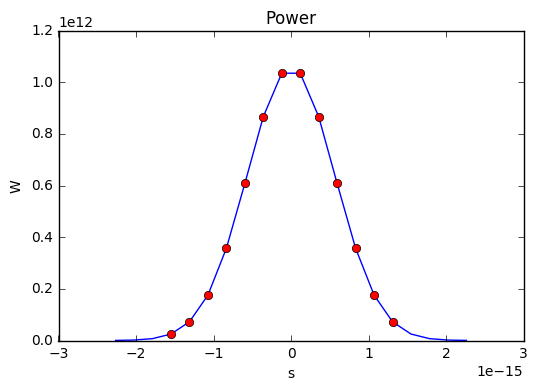

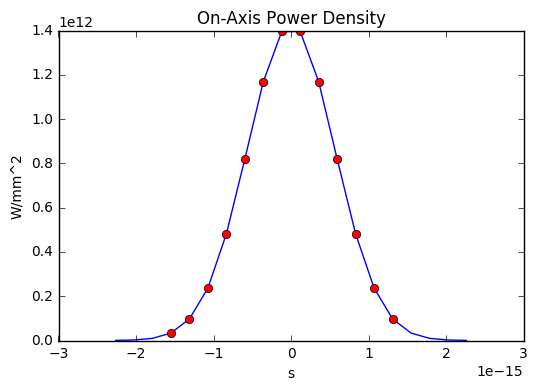

number of meaningful slices: 13
Pulse energy 1.4896 mJ
R-space
(400,) (400,)


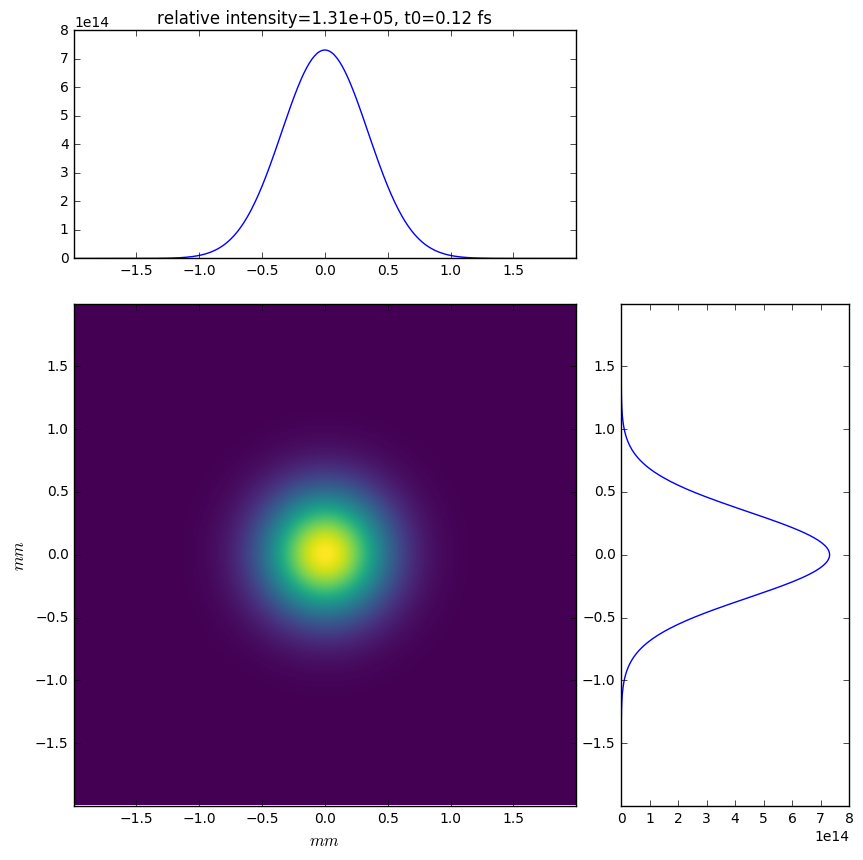

Q-space
{'fwhm_x': 3.1624563970588234e-06, 'fwhm_y': 3.1624563970588234e-06}
Q-space
(400,) (400,)


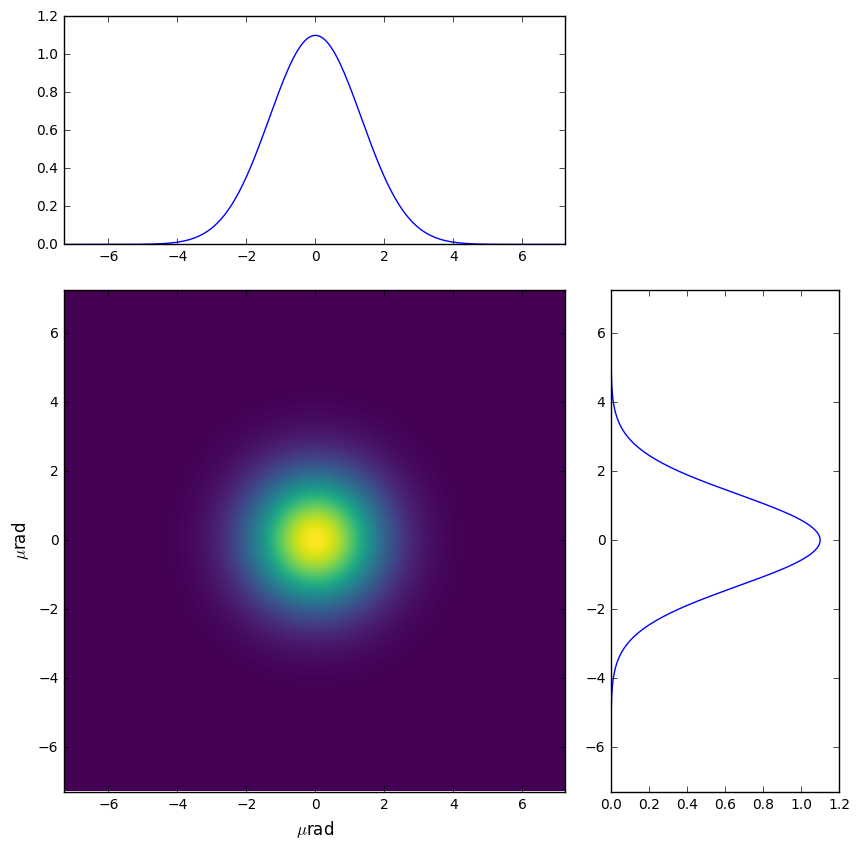

In [9]:
plot_wf(wf)
look_at_q_space(wf)

### propagate through the beamline

nx,ny: 801 91
length: 900.0 mm, width: 30.0 mm
HOM1 WF distortion


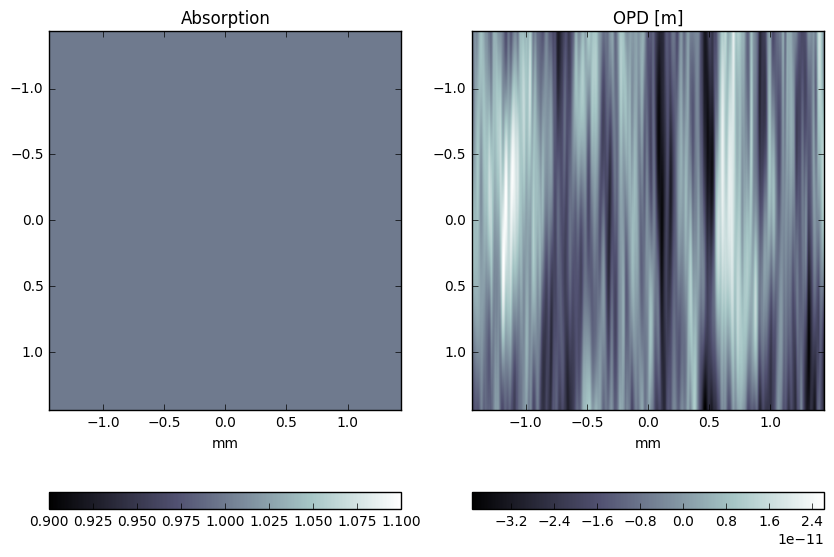

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.00288
	Dy = 0.00288
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.2, 1.4999999999999998, 1.2, 1.4999999999999998, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0014399968896
		xStart = -0.0014399968896
		yFin = 0.00144
		yStart = -0.00144
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 10.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.3333333333333333, 1.0, 1.3333333333333333, 0, 0, 0]
	Dx = 0.00288
	Dy = 0.00288
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. 

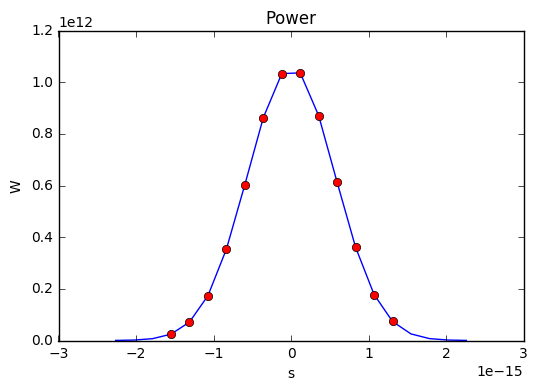

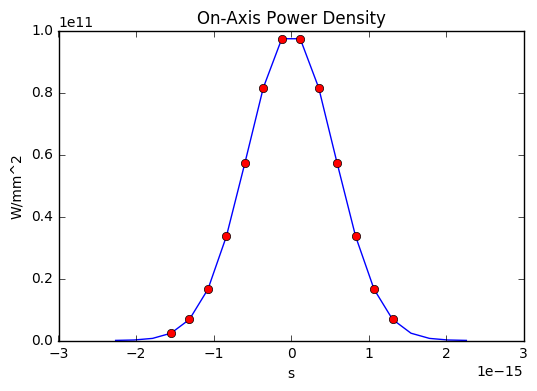

number of meaningful slices: 13
Pulse energy 1.4893 mJ
R-space
(960,) (960,)


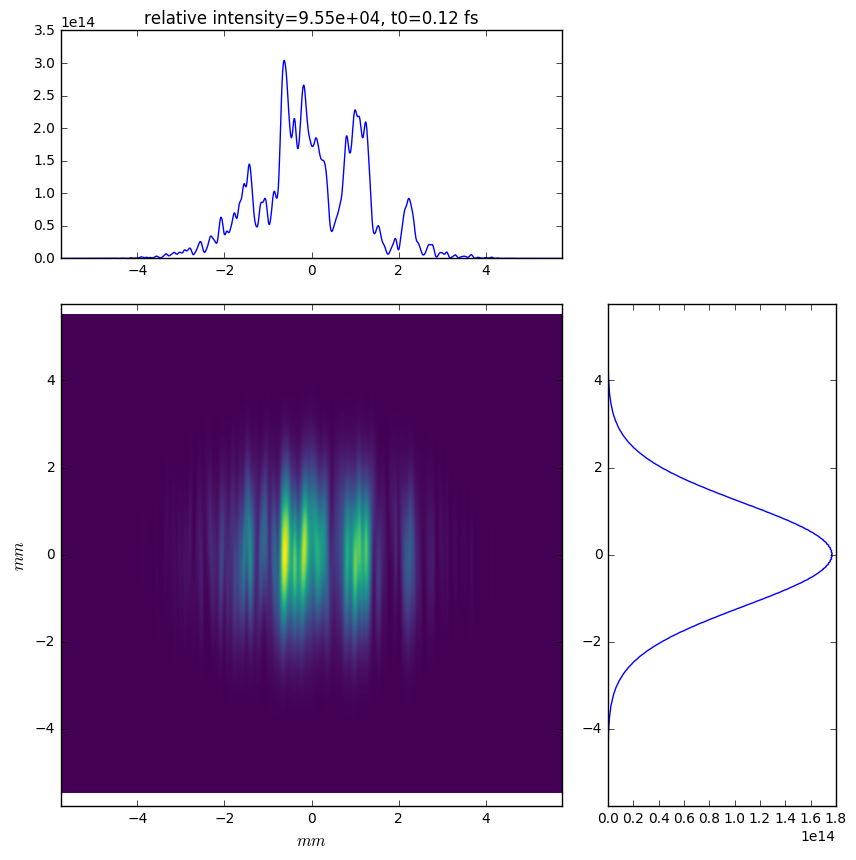

Q-space
{'fwhm_x': 1.238609092839688e-06, 'fwhm_y': 3.0529721720366063e-06}
Q-space
(960,) (960,)


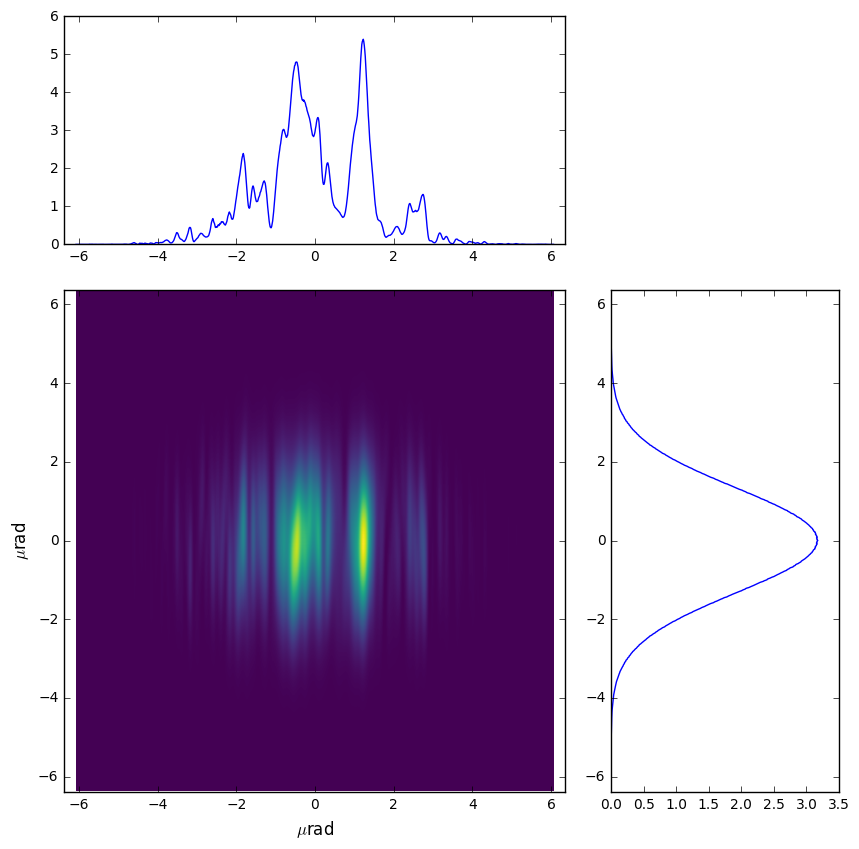

In [10]:
#loading beamline from file
import imp
custom_beamline = imp.load_source('custom_beamline', 'tutorial2_beamline_mirror_2d.py')
get_beamline = custom_beamline.get_beamline
bl = get_beamline()
print(bl)

wf = Wavefront();wf.load_hdf5(os.path.join(data_path,fname+'.h5'))
srwl.SetRepresElecField(wf._srwl_wf, 'f') # <---- switch to frequency domain
bl.propagate(wf)
srwl.SetRepresElecField(wf._srwl_wf, 't')


### show propagated wavefront

xx=calculate_fwhm(wf);
print('FWHM propagated beam: {:.2f} x {:.2f} mm2'.format(xx[u'fwhm_x']*1e3,xx[u'fwhm_y']*1e3));
plot_wf(wf)
look_at_q_space(wf)    

### save propagated pulse 

In [11]:
src_to_imager = 887.8 # distance source to imager 
z = src_to_imager
fname = '{:s}_prop_mir_2d_at_{:03d}m'.format(bname,int(8))
if bSaved:     
    wf.store_hdf5(os.path.join(data_path,fname+'.h5')); 
    print('saving WF to {:s}'.format(os.path.join(data_path,fname+'.h5')))


saving WF to data_wpg_tutorial_02/gb_at_258_m_prop_mir_2d_at_008m.h5
